In [9]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
from IPython.display import Image

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [10]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

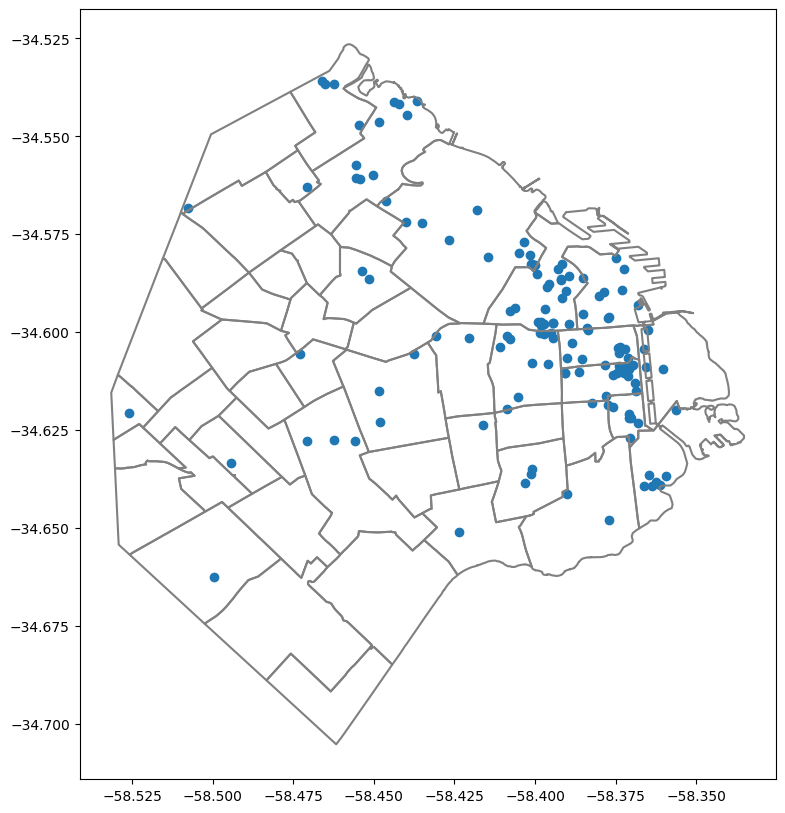

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [11]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()


### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [12]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila <= fila[np.argsort(fila)[m]] )
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [13]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

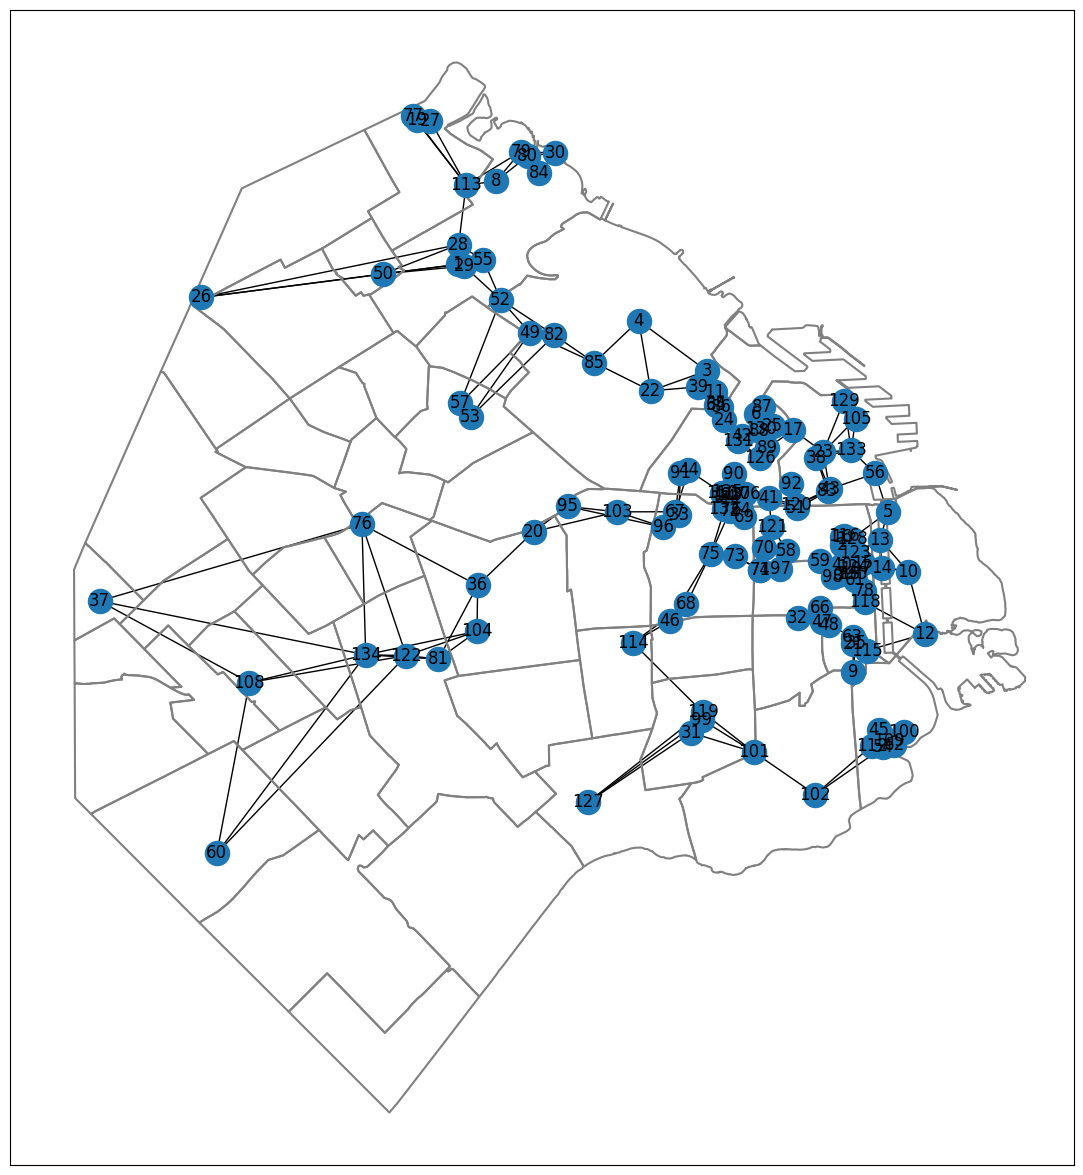

In [14]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1: Partiendo de la ecuacion 3, muestre que el vector de rankings p es solucion de la ecuacion
Mp = b, con M = (N/α)(I − (1 − α)C) y b = 1.

Ecuacion 3: p = (1 − α) C p + (α/N)(1). 
Queremos ver que el vector de rankings anterior p es solucion de la ecuacion Mp = b con M = (N/α)(I − (1 − α)C) y b = 1.

Si partimos de la ecuacion de p tenemos: 

                       p = (1 − α) C p + (α/N)(1)   

        p - (1 − α) C p  = (α/N)(1) 

         (I - (1 - α)C)p = (α/N)(1) 

    (N/α)(I - (1 - α)C)p = (α/N)(1)(N/α)

    (N/α)(I - (1 - α)C)p = (1) 
    
                      Mp = b

Luego el vector p es solucion de la ecuacion Mp = b

            2. ¿Que condiciones se deben cumplir para que exista una unica solucion a la ecuacion del
            punto anterior? ¿Se cumplen estas condiciones para la matriz M tal como fue construida
            para los museos, cuando 0 < α < 1? Demuestre que se cumplen o de un contraejemplo.

Para que la ecuacion Mp = b tenga una unica solucion la matriz M = (N/α)(I − (1 − α)C) debe ser inversible y para que esto ocurra la matriz C debe serlo dado que I es inversible y (N/α) y (1 − α) no influyen en la inversibilidad.
Sabemos que C es la matriz de Transiciones C = AtK(-1) donde A es la matriz de adyacencias entre los m museos mas cercanos de uno particular y K es la matriz de probabilidad de ir desde el museo i al j. 

Analizamos K:

    Sabemos que K es una matriz diagonal por como esta definida. Es la sumatoria desde h = i hasta N de Aih cuando estamos en la posicion ii y 0 en caso contrario. Dado que estamos en el caso en el que la matriz A no es pesada, esta sumatoria nos daria m en cada posicion de la diagonal. Luego dado que todos los numeros de la diagonal son positivos el determinante de K no es cero por lo tanto es inversible.

Analizamos A:

    La matriz A esta determinada por el parametro m que es la cantidad de museos mas cercanos que tomamos en cuenta como posibilidades a la hora de ir de un museo a otro. Las columnas de A (las filas de At) representan los museos que tienen cerca a un museo i. Teniendo esto en cuenta notamos que podria pasar que un museo particular no este dentro de los m mas cercanos de ninguno, generando que hubiera una fila (de At) completa de 0. Esto implicaria que la matriz At no fuera inversible, por ende tampoco su multiplicacion con K(-1).

Dado esto, podemos concluir que no necesariamente la matriz C es inversible y consecuentemente tampoco M. Para que lo fueran deberia pasar que todo museo este dentro de los mas cercanos de aunque sea uno.

[[0 0 1 1]
 [0 0 1 1]
 [1 0 0 1]
 [1 0 1 0]]


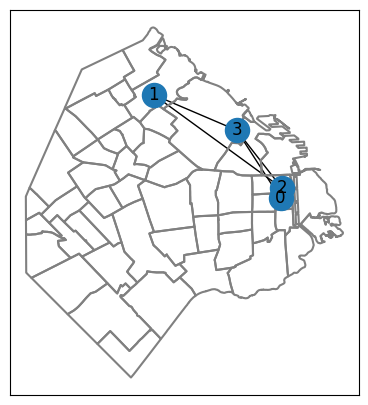

In [15]:

barrios.boundary.plot(color='gray',ax=ax)

D2 = museos[:4].to_crs("EPSG:22184").geometry.apply(lambda g: museos[:4].to_crs("EPSG:22184").distance(g)).round().to_numpy()
B = construye_adyacencia(D2,2)
G2 = nx.from_numpy_array(B) 
G2_layout = {i:v for i,v in enumerate(zip(museos[:4].to_crs("EPSG:22184").get_coordinates()['x'],museos[:4].to_crs("EPSG:22184").get_coordinates()['y']))}
fig, ax = plt.subplots(figsize=(5, 5)) 
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) 
nx.draw_networkx(G2,G2_layout,ax=ax)

print(B)

Como podemos ver en la matriz y en la figura anterior, el museo 1 esta demasiado alejado del resto como para estar dentro de los mas cercanos de otro, generando una columna de ceros en la matriz de adyacencias resultando posteriormente en una C no inversible.

In [17]:
def calculaLU(matriz):
    U = np.copy(matriz)
    L = np.zeros_like(matriz)

    for fila in range(len(matriz)):
        for col in range(fila+1, len(matriz)):
            coeficiente = U[col][fila] / U[fila][fila]
            L[col][fila] = coeficiente
            for k in range(fila, len(matriz)):
                U[col][k] -= coeficiente * U[fila][k]

    for i in range(len(matriz)):
        L[i][i] = 1
    return L, U

In [18]:
def calcula_matriz_C(A): 
    suma_col = np.sum(A, axis = 1)
    K = np.diag(suma_col)
    n = A.shape[0]
    Kinv = np.zeros((n, n))
    for i in range(n):
        if K[i, i] != 0:
            Kinv[i, i] = 1.0 / K[i, i] # Calcula inversa de la matriz K, que tiene en su diagonal la suma por filas de A traspuesta
    C = A.T @ Kinv  # Calcula C multiplicando Kinv y A

    return C

In [39]:
def punto_tres(m, alpha):
    A = construye_adyacencia(D,m)
    C = calcula_matriz_C(A)
    N = C.shape[0]
    b = np.ones(N)
    M = (N / alpha) * (np.identity(N) - (1-alpha) * C)

    L, U = calculaLU(M)

    y = scipy.linalg.solve_triangular(L, b, lower=True)
    p = scipy.linalg.solve_triangular(U, y, lower=False)

    return p


In [40]:
def punto_tres_testing_img(m, alpha):
    A = construye_adyacencia(D,m)
    C = calcula_matriz_C(A)
    N = C.shape[0]
    b = np.ones(N)
    M = (N / alpha) * (np.identity(N) - (1-alpha) * C)

    L, U = calculaLU(M)

    y = scipy.linalg.solve_triangular(L, b, lower=True)
    p = scipy.linalg.solve_triangular(U, y, lower=False)

    return p, A

1 puesto:  Museo de Odontología
2 puesto:  Museo de la Facultad de Odontología
3 puesto:  Museo de Farmacobotánica


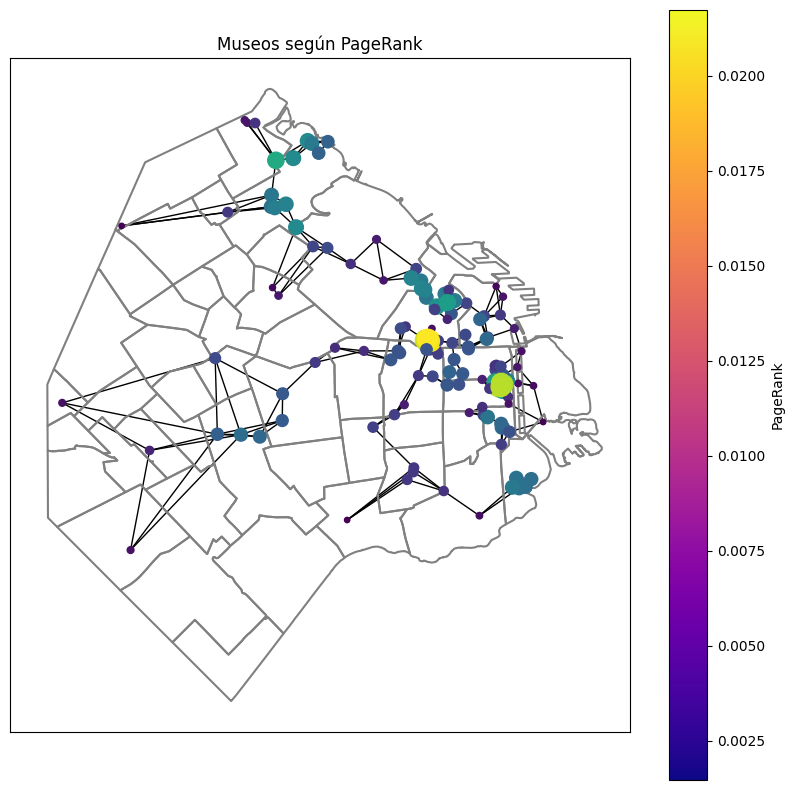

In [48]:
p, B = punto_tres_testing_img(m=5, alpha=1/5)
invertido = np.argsort(p)[::-1]
print("1 puesto: ",museos.iloc[invertido[0]]['name'])
print("2 puesto: ",museos.iloc[invertido[1]]['name'])
print("3 puesto: ",museos.iloc[invertido[2]]['name'])

G2 = nx.from_numpy_array(B)
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G, G_layout, node_size=p*factor_escala, with_labels=False, ax=ax, node_color=p, edge_cmap=plt.cm.plasma)
escala = plt.cm.ScalarMappable(cmap=plt.cm.plasma)
escala.set_array(p)
plt.colorbar(escala, ax=ax, label='PageRank')
plt.title("Museos según PageRank")
plt.show() 


Si bien la red está bastante repartida por todo el territorio, se destacan algunos puntos clave con nodos grandes y claros que actúan como centros de influencia en distintas zonas.

+ En la zona noreste (correspondiente a los barrios más céntricos de CABA como Recoleta, San Nicolás o Retiro), hay una fuerte concentración de nodos grandes y de colores claros/amarillos.
Esto indica que los museos más importantes o influyentes de la red se encuentran ahí por lo que tienen alto PageRank, es decir, muchas conexiones o vínculos con otros museos que también son relevantes.

+ En los extremos del mapa (sobre todo hacia el sur y el oeste) los nodos son más chicos y oscuros. Esto indica que esos museos tienen un PageRank bajo, lo que podría implicar menor cantidad de visitas o menos conexiones con el resto de la red.

TypeError: cannot unpack non-iterable int object

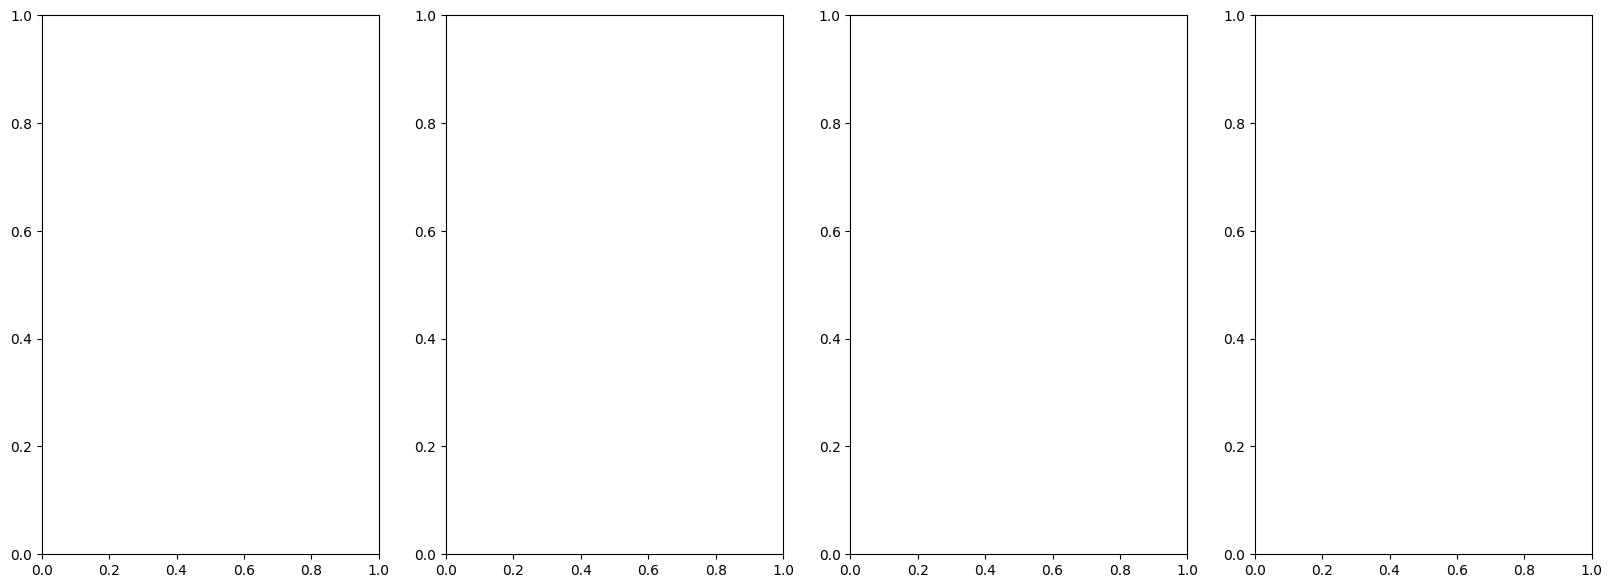

In [ ]:
valores = []
for m in [1, 3, 5, 10]:
    print("--------", m, "--------")
    p = punto_tres(m=m, alpha=1/5)
    masImportantes = np.argsort(p)[::-1][:3]

    for pos, idx in enumerate(masImportantes):
        valores.append({
            "m": m,
            "rank": pos,
            "museo": museos.iloc[idx]['name'],
            "puntaje": p[idx]
        })

df = pd.DataFrame(valores)

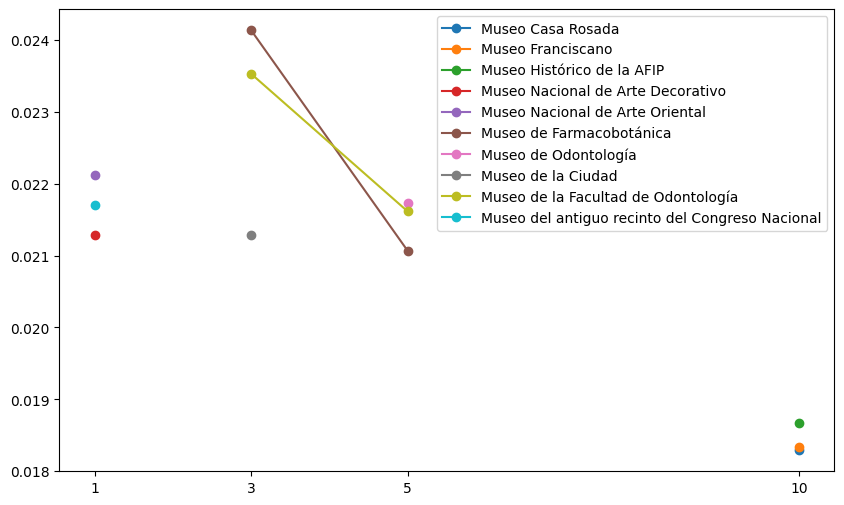

In [54]:
plt.figure(figsize=(10, 6))
for museo, puntaje in df.groupby("museo"):
    plt.plot(puntaje["m"], puntaje["puntaje"], 
             label=museo, marker="o")
plt.xticks([1,3,5,10])
plt.legend()
plt.show()


In [63]:
valores2 = []
for alpha in [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]:
    print("--------", alpha, "--------")
    p = punto_tres(m=5, alpha=alpha)
    masImportantes = np.argsort(p)[::-1][:3]

    for pos, idx in enumerate(masImportantes):
        valores2.append({
            "alpha": alpha,
            "rank": pos,
            "museo": museos.iloc[idx]['name'],
            "puntaje": p[idx]
        })

df2 = pd.DataFrame(valores2)

-------- 0.8571428571428571 --------
-------- 0.8 --------
-------- 0.6666666666666666 --------
-------- 0.5 --------
-------- 0.3333333333333333 --------
-------- 0.2 --------
-------- 0.14285714285714285 --------


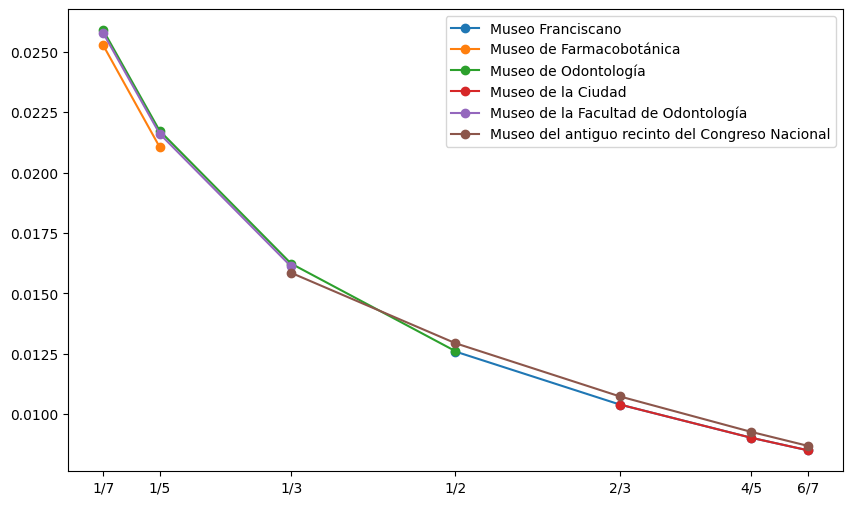

In [64]:
plt.figure(figsize=(10, 6))
for museo, puntaje in df2.groupby("museo"):
    plt.plot(puntaje["alpha"], puntaje["puntaje"], 
             label=museo, marker="o")
plt.xticks([6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7],
           ["6/7", "4/5", "2/3", "1/2", "1/3", "1/5", "1/7"])

plt.legend()
plt.show()

## Punto 3:


## Punto 4:

## Punto 5:

## Punto 6:

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, '15'),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 1

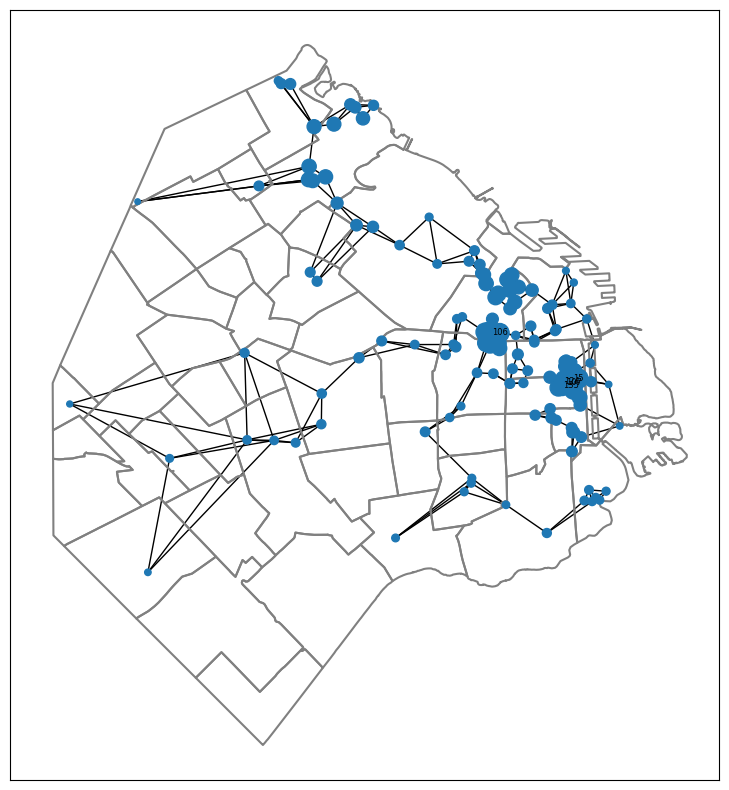

In [16]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = punto_tres(m=m, alpha=1/5)# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres